In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import optuna

import numpy as np

c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from sklearn.metrics import make_scorer

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Calculate validation score using MAPE
    y_pred = model.predict(X_val)
    mape = -np.mean(np.abs((y_val - y_pred) / y_val)) * 100  # Negative because we want to maximize
    
    return mape

study = optuna.create_study(direction='maximize')  # maximize because we're using negative MAPE
study.optimize(objective, n_trials=30)

print("Best hyperparameters:", study.best_trial.params)


[I 2025-03-10 20:45:59,938] A new study created in memory with name: no-name-2d88531d-74be-4a1b-938a-3457ace0b083
[I 2025-03-10 20:46:03,202] Trial 0 finished with value: -3.44301588330366 and parameters: {'n_estimators': 240, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: -3.44301588330366.
[I 2025-03-10 20:46:04,760] Trial 1 finished with value: -3.652075708891905 and parameters: {'n_estimators': 135, 'max_depth': 13, 'min_samples_split': 12, 'min_samples_leaf': 15}. Best is trial 0 with value: -3.44301588330366.
[I 2025-03-10 20:46:05,031] Trial 2 finished with value: -7.160426910533886 and parameters: {'n_estimators': 59, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 9}. Best is trial 0 with value: -3.44301588330366.
[I 2025-03-10 20:46:09,143] Trial 3 finished with value: -3.5055937709322222 and parameters: {'n_estimators': 265, 'max_depth': 20, 'min_samples_split': 13, 'min_samples_leaf': 1}. Best is trial 0 with value: 

Best hyperparameters: {'n_estimators': 240, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 2}


In [3]:
merged_df = pd.read_csv('merged_df.csv')



merged_df['Data'] = pd.to_datetime(merged_df['Data_x'])
merged_df['hour'] = merged_df['Data'].dt.hour.astype(str)
merged_df['day_of_week'] = merged_df['Data'].dt.dayofweek.astype(str)
merged_df['week_of_year'] = merged_df['Data'].dt.isocalendar().week.astype(str)
merged_df['previous_day_value'] = merged_df['value'].shift(24)

# # Prepare the data
# train['Data'] = pd.to_datetime(train['Data_x'])
# train['hour'] = train['Data'].dt.hour.astype(str)
# train['day_of_week'] = train['Data'].dt.dayofweek.astype(str)
# train['week_of_year'] = train['Data'].dt.isocalendar().week.astype(str)

# # Remove commas and convert 'forecast' column to float

# # Add previous day's value
# train['previous_day_value'] = train['value'].shift(24)
# # Prepare the data
# test['Data'] = pd.to_datetime(test['Data_x'])
# test['hour'] = test['Data'].dt.hour.astype(str)
# test['day'] = test['Data'].dt.day
# test['month'] = test['Data'].dt.month
# test['day_of_week'] = test['Data'].dt.dayofweek.astype(str)
# test['week_of_year'] = test['Data'].dt.isocalendar().week.astype(str)


# # Add previous day's value
# test['previous_day_value'] = test['value'].shift(24)

# Split the data into train and test sets
train_size = int(len(merged_df) * 0.8)
train = merged_df[:train_size]
test = merged_df[train_size:]

# Define features and target
# Split the training data into training and validation sets
X_train_full = train[['hour', 'day_of_week', 'week_of_year', 'previous_day_value','Usłonecznienie [godziny]',"Suma dobowa opadu [mm]","Dzień wolny","sun"]]
y_train_full = train['value']

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, shuffle=False)

X_test = test[['hour', 'day_of_week', 'week_of_year', 'previous_day_value',"Usłonecznienie [godziny]","Suma dobowa opadu [mm]","Dzień wolny","sun"]]
y_test = test['value']

#  {'n_estimators': 227, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 2}
# Best hyperparameters: {'n_estimators': 157, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2}
#  {'n_estimators': 176, 'max_depth': 13, 'min_samples_split': 13, 'min_samples_leaf': 3}
# Create and train the model
model = RandomForestRegressor(n_estimators=176, random_state=10, max_depth=13, min_samples_split=13, min_samples_leaf=3)
model.fit(X_train, y_train)


print("train results")
y_pred_train = model.predict(X_train)
mape = (abs((y_pred_train - y_train) / y_train).mean()) * 100
print(f'Mean Absolute Percentage Error: {mape}%')



print("Val results")
y_pred_val = model.predict(X_val)
mape = (abs((y_pred_val - y_val) / y_val).mean()) * 100
print(f'Mean Absolute Percentage Error: {mape}%')



print("test results")
y_pred = model.predict(X_test)
mape = (abs((y_test - y_pred) / y_test).mean()) * 100
print(f'Mean Absolute Percentage Error: {mape}%')


train results
Mean Absolute Percentage Error: 1.372645139932907%
Val results
Mean Absolute Percentage Error: 3.506544717678592%
test results
Mean Absolute Percentage Error: 4.1544522752847755%


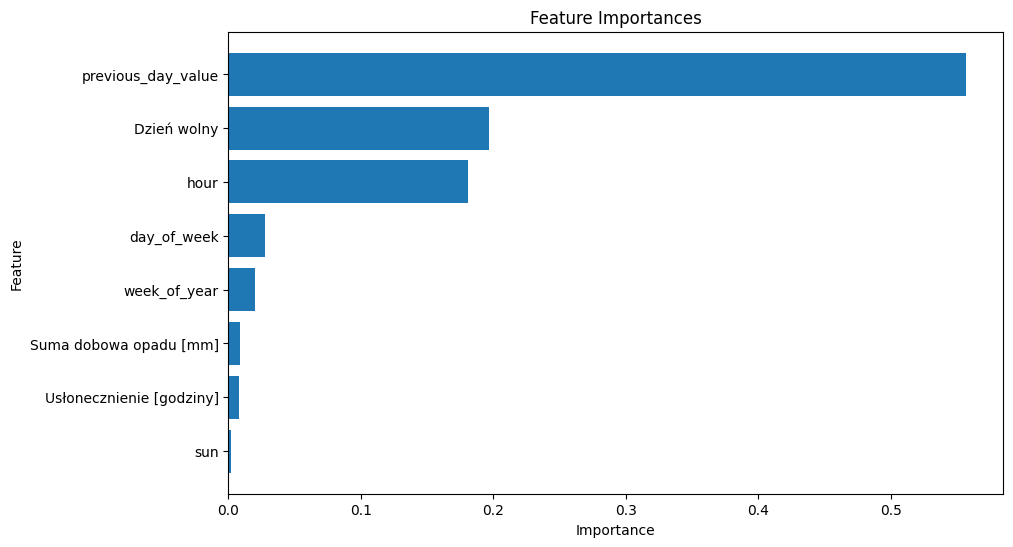

In [13]:
import matplotlib.pyplot as plt

# Get feature importances
importances = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Calculate MAPE using the 'forecast' column as predictions

mape = (abs((test["value"]  - test['forecast']) / y_test).mean()) * 100
print(f'Mean Absolute Percentage Error: {mape}%')
 

Mean Absolute Percentage Error: 2.3367152471315125%
